# Finding Average SEP duration from Onset to Peak

name: 112, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
448         448  2.455423e+06  2010  226.43403    0.12371     0.0000      1   
449         449  2.455423e+06  2010  226.50000   10.05800    95.4760      2   
450         450  2.455423e+06  2010  226.53819   14.60800    11.6040      3   
451         451  2.455423e+06  2010  226.62500    6.19230    -5.1731      4   

               datetime  
448 2010-08-14 10:25:00  
449 2010-08-14 12:00:00  
450 2010-08-14 12:54:00  
451 2010-08-14 15:00:00  
start time: 2010-08-14 10:25:00, peak_time: 2010-08-14 12:54:00
name: 113, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
452         452  2.455628e+06  2011   66.90278    0.15431     0.0000      1   
453         453  2.455629e+06  2011   67.04861   11.26300    28.6080      2   
454         454  2.455629e+06  2011   67.34028   50.14600     5.0381      3   
455         455  2.455631e+06  2011   69.59722    6.80720 

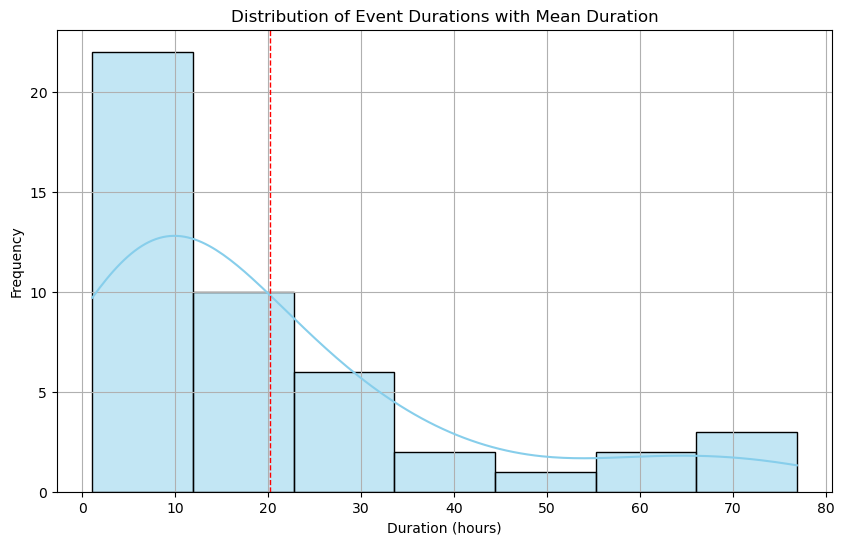

average sep duration: 0 days 20:13:56.086956521, number of seps:46


In [8]:
from dataload.calc_cme_history import calculate_average_duration
import pandas as pd

file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
df = pd.read_csv(file_path)

avg_sep_duration, num_seps = calculate_average_duration(df, start_year=2010, end_year=2017, debug=True)

# print the duration
print(f"average sep duration: {avg_sep_duration}, number of seps:{num_seps}")

# Building the dataset

steps involved in building the dataset. 

identify 46 SEPs and create 46 csv files for each SEP from pf10 file
each csv will have target time, feature time starting from the 

In [9]:
output_dir = "D:/College/Fall2023/electron_cme_data"
sep_file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
cme_file_path = "D:/College/Fall2023/new_data/SEP10MeV_Features.csv"
flux_data_path = 'D:/College/Fall2023/new_data/ephin5m.dat'

In [10]:
import pandas as pd

# Load the dataset
file_path_ds1 = sep_file_path
df_ds1 = pd.read_csv(file_path_ds1)

# Display the first few rows to understand its structure
df_ds1.head()


,Unnamed: 0,Julian Day,Year,DayOfYear,Intensity,%Rate/day,Index,datetime
0,0,2.450011e+06,1995,293.26389,0.11119,0.0000,1,1995-10-20 06:20:00
1,1,2.450011e+06,1995,293.34375,10.93500,70.0420,2,1995-10-20 08:15:00
2,2,2.450011e+06,1995,293.51042,65.14900,11.1010,3,1995-10-20 12:15:00
3,3,2.450012e+06,1995,294.10417,6.93270,-4.1139,4,1995-10-21 02:30:00
4,4,2.450757e+06,1997,308.25347,0.16920,0.0000,1,1997-11-04 06:04:00


In [11]:
def find_sep_times(df, start_year=None, end_year=None):
    """
    Finds the onset time and peak time of each SEP event within a specified start and end year.

    Args:
        df (pd.DataFrame): DataFrame containing the SEP event data.
        start_year (int, optional): The start year for filtering events. Defaults to None.
        end_year (int, optional): The end year for filtering events. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Event', 'Onset Time', 'Peak Time']
    """
    # Convert datetime column to datetime objects
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Filter by year if specified
    if start_year:
        df = df[df['Year'] >= start_year]
    if end_year:
        df = df[df['Year'] <= end_year]

    # Initialize a list to store the event data
    events = []

    # Iterate over the groups (each group should represent an SEP event)
    for event_num, group in enumerate(df.groupby(df.index // 4)):
        group_data = group[1]
        onset_time = group_data[group_data['Index'] == 1]['datetime'].iloc[0]
        peak_time = group_data[group_data['Index'] == 3]['datetime'].iloc[0]
        events.append({'Event': event_num + 1, 'Onset Time': onset_time, 'Peak Time': peak_time})

    # Convert the list to a DataFrame
    sep_times = pd.DataFrame(events)

    return sep_times


In [12]:
# Applying the function to the dataset
sep_times_df = find_sep_times(df_ds1, start_year=2010, end_year=2017)

print(len(sep_times_df))

46


In [56]:
from typing import Dict, List, Optional, Tuple, Any
from datetime import timedelta, datetime
import pandas as pd
from dataload.electron_ts import load_flux_data
from dataload.calc_cme_history import cme_statistics_for_row
import os

In [83]:
def process_group_data(group_data: pd.DataFrame, start_idx: int = 1, end_idx: int = 4) -> Tuple[
    pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp, List[pd.Timestamp], List[pd.Timestamp]]:
    """
    Processes the SEP event group data to extract key timestamps and create target and feature time lists.

    Args:
        group_data (pd.DataFrame): Data frame containing SEP event group data.
        start_idx (int, optional): start index or onset time
        end_idx (int, optional): end index 

    Returns:
        Tuple containing onset time, peak time, start time, target_tplus6 list, and features_t list.
    """
    onset_time = group_data[group_data['Index'] == start_idx]['datetime'].iloc[0]
    peak_time = group_data[group_data['Index'] == 3]['datetime'].iloc[0]
    end_time = group_data[group_data['Index'] == end_idx]['datetime'].iloc[0]
    start_time = onset_time - timedelta(hours=2)

    target_tplus6 = []
    features_t = []
    current_time = start_time
    while current_time <= end_time:
        target_tplus6.append(current_time)
        features_t.append(current_time - timedelta(minutes=30))
        current_time += timedelta(minutes=5)

    # Check if the last timestep matches with the peak time, if not, add an additional timestep
    if target_tplus6[-1] != end_time:
        target_tplus6.append(current_time)
        features_t.append(current_time - timedelta(minutes=30))

    return onset_time, peak_time, start_time, end_time, target_tplus6, features_t


def initialize_event_dict(
        onset_time: pd.Timestamp,
        peak_time: pd.Timestamp,
        start_time: pd.Timestamp,
        end_time: pd.Timestamp,
        avg_sep_duration: timedelta) -> Dict[str, Any]:
    """
    Initializes the event dictionary with basic time data structure.

    Args:
        onset_time (pd.Timestamp): The onset time of the SEP event.
        peak_time (pd.Timestamp): The peak time of the SEP event.
        start_time (pd.Timestamp): The start time of the SEP event.
        end_time (pd.Timestamp): The end time of the SEP event.
        avg_sep_duration (timedelta): The average duration of an SEP event.

    Returns:
        Dict[str, Any]: A dictionary with the initialized time data for the event.
    """
    return {
        'onset_time': onset_time,
        'peak_time': peak_time,
        'start_time': start_time,
        'end_time': end_time,
        'avg_sep_duration': avg_sep_duration
    }


def create_flux_dict(timestamps: List[pd.Timestamp], ds3_flux: pd.DataFrame, flux_channel: str) -> Dict[
    pd.Timestamp, float]:
    """
    Creates a dictionary mapping each timestamp to its corresponding flux intensity from the specified channel.

    Args:
        timestamps (List[pd.Timestamp]): List of timestamps to map to flux intensities.
        ds3_flux (pd.DataFrame): DataFrame containing the flux data.
        flux_channel (str): The flux channel to use for intensity values.

    Returns:
        Dict[pd.Timestamp, float]: A dictionary mapping timestamps to flux intensities.
    """
    flux_dict = {}
    for time in timestamps:
        closest_time = ds3_flux.index.get_loc(time, method='nearest')
        flux_intensity = ds3_flux.loc[ds3_flux.index[closest_time], flux_channel]
        flux_dict[time] = flux_intensity
    return flux_dict


def process_cme_data(event_dict: Dict[str, Any], ds2: pd.DataFrame, features_t: List[pd.Timestamp],
                     cme_offset: timedelta, avg_sep_duration: timedelta) -> None:
    """
    Processes CME data and updates the event dictionary with detailed CME attributes.

    Args:
        event_dict (Dict[str, Any]): The event dictionary to update with CME data.
        ds2 (pd.DataFrame): DataFrame containing CME data with various attributes.
        features_t (List[pd.Timestamp]): List of feature timestamps.
        cme_offset (timedelta): Time offset for CME events.
        avg_sep_duration (timedelta): Average duration of an SEP event.
    """
    # Define the CME attributes to extract
    cme_attributes = ['CME_DONKI_latitude', 'CME_DONKI_longitude', 'CME_DONKI_speed',
                      'CME_CDAW_MPA', 'CME_CDAW_LinearSpeed', 'VlogV', 'DONKI_half_width',
                      'Accelaration', '2nd_order_speed_final', '2nd_order_speed_20R',
                      'CPA', 'Halo', 'Type2_Viz_Area', 'solar_wind_speed', 'diffusive_shock',
                      'half_richardson_value']

    cmes = {time: 0 for time in features_t}  # Default value is 0 for each timestamp
    for cme_time in ds2['CME_DONKI_time']:
        if features_t[0] <= cme_time <= features_t[-1]:  # Check if CME is within the event time window
            cme_start_index = next((i for i, time in enumerate(features_t) if time >= cme_time + cme_offset), None)
            if cme_start_index is not None:
                cme_data = ds2[ds2['CME_DONKI_time'] == cme_time].iloc[0]
                cme_info = {attr: cme_data[attr] for attr in cme_attributes}
                cme_info['cme_donki_time'] = cme_time

                for i in range(cme_start_index,
                               min(cme_start_index + avg_sep_duration // timedelta(minutes=5), len(features_t))):
                    cmes[features_t[i]] = cme_info

    event_dict['cmes'] = cmes


def validate_list_lengths(event_dict: Dict[str, Any], event_num: int) -> None:
    """
    Validates if all list-type values in the event dictionary have the same length and prints an appropriate message.

    Args:
        event_dict (Dict[str, Any]): The event dictionary to validate.
        event_num (int): The number of the current event being processed.
    """
    list_lengths = [len(v) for k, v in event_dict.items() if
                    isinstance(v, list) or isinstance(v, dict)]  # Check for lists and dictionaries
    if not list_lengths:
        print(f"No lists or dictionaries found in event {event_num}.")
        return

    common_length = list_lengths[0]
    if all(length == common_length for length in list_lengths):
        print(f"All lists in event {event_num} have a common length of {common_length}.")
    else:
        print(f"Error: Lists in event {event_num} do not have a common length.")


def get_daily_sunspot_numbers(ds2: pd.DataFrame, features_t: List[pd.Timestamp]) -> List[Optional[int]]:
    """
    Retrieves the daily sunspot numbers for each timestamp in features_t from ds2.

    Args:
        ds2 (pd.DataFrame): DataFrame containing CME and sunspot data.
        features_t (List[pd.Timestamp]): List of timestamps for which to retrieve daily sunspot numbers.

    Returns:
        List[Optional[int]]: List of daily sunspot numbers corresponding to each timestamp in features_t.
    """
    # Convert CME_DONKI_time to just dates in ds2 for easier matching
    ds2['Date'] = ds2['CME_DONKI_time'].dt.date

    daily_sunspot_nums = []
    for time in features_t:
        matched_row = ds2[ds2['Date'] == time.date()]
        sunspot_number = matched_row['daily_sunspots'].iloc[0] if not matched_row.empty else None
        daily_sunspot_nums.append(sunspot_number)

    return daily_sunspot_nums


def save_event_data_to_csv(event_id: int, event_dict: Dict[str, Any], output_path: str) -> None:
    """
    Saves the data for a specific SEP event to a CSV file.

    This function creates a DataFrame from the event data dictionary and saves it as a CSV file in the specified output path.
    The CSV file includes various data points for each timestamp in the event.

    Args:
        event_id (int): The unique identifier of the SEP event.
        event_dict (Dict[str, Any]): A dictionary containing the detailed time data for the SEP event.
        output_path (str): The directory path where the CSV file will be saved.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Calculate Target Timestamps (assuming a fixed offset, e.g., 30 minutes)
    target_timestamps = [ts + timedelta(minutes=30) for ts in event_dict['features_t']]

    # Prepare data for DataFrame
    df_data = {
        'Event ID': [event_id] * len(event_dict['features_t']),
        'Timestamp': event_dict['features_t'],
        'Target Timestamp': target_timestamps,
        'Proton Intensity': list(event_dict['target_tplus6'].values()),  # Grab only values
    }

    # Add tminus... and t columns
    for i in range(24, 0, -1):
        tminus_key = f'tminus{i}'
        df_data[tminus_key] = list(event_dict[tminus_key].values())
    
    # Add 't' column
    df_data['t'] = list(event_dict['t'].values())

    # Max Electron Intensity and other columns
    df_data['Max Electron Intensity'] = event_dict['max_electron_intensity']
    df_data['Sunspot Number'] = event_dict['daily_sunspot_num']

    # Flatten CME Attributes
    cme_keys = ['cme_donki_time', 'CME_DONKI_latitude', 'CME_DONKI_longitude', 'CME_DONKI_speed',
                'CME_CDAW_MPA', 'CME_CDAW_LinearSpeed', 'VlogV', 'DONKI_half_width',
                'Accelaration', '2nd_order_speed_final', '2nd_order_speed_20R',
                'CPA', 'Halo', 'Type2_Viz_Area', 'solar_wind_speed', 'diffusive_shock',
                'half_richardson_value']
    for key in cme_keys:
        cme_attribute_list = []
        for ts in event_dict['features_t']:
            if isinstance(event_dict['cmes'][ts], dict):
                cme_attribute_list.append(event_dict['cmes'][ts].get(key, 0))
            else:
                cme_attribute_list.append(0)
        df_data[key] = cme_attribute_list

    # Add CME Counts and Speeds
    df_data['CMEs Past Month'] = event_dict['CMEs_in_past_month']
    df_data['CMEs Past 9 Hours'] = event_dict['CMEs_in_past_9hours']
    df_data['CMEs Speed > 1000'] = event_dict['CMEs_with_speed_over_1000_in_past_9hours']
    df_data['Max CME Speed'] = event_dict['max_CME_speed_in_past_day']
    
    # print('df_data: ')
    # print(df_data)

    # Create DataFrame
    df = pd.DataFrame(df_data)

    # Save the DataFrame to a CSV file
    filename = os.path.join(output_path, f"sep_event_{event_id}.csv")
    df.to_csv(filename, index=False)


def dump_event(event_id: int, event_dict: Dict[str, Any], output_path: str) -> None:
    """
    Dumps the SEP event data dictionary into a text file.

    Args:
        event_id (int): The unique identifier of the SEP event.
        event_dict (Dict[str, Any]): A dictionary containing the detailed time data for the SEP event.
        output_path (str): The directory path where the text file will be saved.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Construct the filename for the text file
    filename = os.path.join(output_path, f"sep_event_{event_id}.txt")

    # Dump the event data into a text file
    with open(filename, 'w') as file:
        file.write(str(event_dict))



In [84]:
def generate_event_time_data(sep_path: str, cme_path: str, flux_path: str,
                             start_year: Optional[int] = None,
                             end_year: Optional[int] = None,
                             cme_offset: timedelta = timedelta(minutes=30),
                             avg_sep_duration: timedelta = timedelta(days=0, hours=20, minutes=13, seconds=56,
                                                                     microseconds=86956),
                             proton_flux_channel: str = 'Proton_Flux_16.40MeV',
                             electron_flux_channel: str = 'Electron_Flux_0.5MeV',
                             output_path: str = "D:/College/Fall2023/electron_cme_data") -> Dict[
    int, Dict[str, Dict[pd.Timestamp, float]]]:
    """
    Generates detailed time data for each SEP event in ds1, including CME times from ds2, proton flux, and electron flux data.

    Args:
        sep_path (str): Path to the SEP events data file.
        cme_path (str): Path to the CME features data file.
        flux_path (str): Path to the flux data file.
        start_year (Optional[int]): Start year for filtering SEP events. Defaults to None.
        end_year (Optional[int]): End year for filtering SEP events. Defaults to None.
        cme_offset (timedelta): Time offset for CME events.
        avg_sep_duration (timedelta): Average duration of an SEP event.
        proton_flux_channel (str): Proton flux channel to be used for target_tplus6 data.
        electron_flux_channel (str): Electron flux channel to be used for tminus data.
        output_path (str): Path for saving the output data.

    Returns:
        Dict[int, Dict[str, Dict[pd.Timestamp, float]]]: A dictionary with detailed time data for each SEP event.
    """
    # Load data
    ds1 = pd.read_csv(sep_path)  # SEP events
    ds2 = pd.read_csv(cme_path)  # CME features
    ds3_flux = load_flux_data(flux_path)  # Flux data

    # Convert datetime columns to datetime objects and filter ds1 by year
    ds1['datetime'] = pd.to_datetime(ds1['datetime'])
    ds2['CME_DONKI_time'] = pd.to_datetime(ds2['CME_DONKI_time'], format='%m/%d/%Y %H:%M')
    if start_year: ds1 = ds1[ds1['Year'] >= start_year]
    if end_year: ds1 = ds1[ds1['Year'] <= end_year]

    event_time_data = {}

    for event_num, group in enumerate(ds1.groupby(ds1.index // 4)):
        # if event_num > 7: break  # for debugging purposes
        group_data = group[1]
        onset_time, peak_time, start_time, end_time, target_tplus6, features_t = process_group_data(group_data)
        event_dict = initialize_event_dict(onset_time, peak_time, start_time, end_time, avg_sep_duration)

        # Make sure to add 'features_t' to the event_dict
        event_dict['features_t'] = features_t

        # Create target_tplus6 with proton intensities
        event_dict['target_tplus6'] = create_flux_dict(target_tplus6, ds3_flux, proton_flux_channel)

        # Process CME data and add cmes to the event dictionary
        process_cme_data(event_dict, ds2, features_t, cme_offset, avg_sep_duration)

        # Create tminus... dictionaries with electron intensities
        for i in range(24, 0, -1):
            key_name = f'tminus{i}'
            event_dict[key_name] = create_flux_dict([time - timedelta(minutes=i * 5) for time in features_t],
                                                    ds3_flux,
                                                    electron_flux_channel)

        # Set 't' key as features_t with electron intensities
        event_dict['t'] = create_flux_dict(features_t, ds3_flux, electron_flux_channel)

        # Calculate max electron intensity for each timestamp
        max_electron_intensities = []
        for time in features_t:
            # Gather intensities from all tminus... and t dictionaries for this timestamp
            intensities_at_time = [event_dict.get(f'tminus{24 - i}', {}).get(time, 0) for i in range(24)]
            intensities_at_time.append(event_dict.get('t', {}).get(time, 0))  # Add intensity from 't'

            # Determine the maximum intensity at this timestamp
            max_intensity = max(intensities_at_time)
            max_electron_intensities.append(max_intensity)

        # Add max_electron_intensity to the event dictionary
        event_dict['max_electron_intensity'] = max_electron_intensities

        # Initialize lists for the new keys
        past_month_counts = []
        past_9hr_counts = []
        past_9hr_speed_counts = []
        past_day_max_speeds = []

        # Calculate CME statistics for each timestamp in features_t
        for time in features_t:
            month_count, _9hr_count, _9hr_speed_count, day_max_speed = cme_statistics_for_row(ds2, time)
            past_month_counts.append(month_count)
            past_9hr_counts.append(_9hr_count)
            past_9hr_speed_counts.append(_9hr_speed_count)
            past_day_max_speeds.append(day_max_speed)

        # Add new keys to the event dictionary
        event_dict['CMEs_in_past_month'] = past_month_counts
        event_dict['CMEs_in_past_9hours'] = past_9hr_counts
        event_dict['CMEs_with_speed_over_1000_in_past_9hours'] = past_9hr_speed_counts
        event_dict['max_CME_speed_in_past_day'] = past_day_max_speeds

        # Get daily sunspot numbers for each timestamp in features_t
        daily_sunspot_nums = get_daily_sunspot_numbers(ds2, features_t)

        # Add daily_sunspot_num to the event dictionary
        event_dict['daily_sunspot_num'] = daily_sunspot_nums

        # Validate list lengths and add nticks
        validate_list_lengths(event_dict, event_num + 1)
        event_dict['nticks'] = len(event_dict['features_t'])

        event_time_data[event_num + 1] = event_dict
        # Save event data to CSV
        save_event_data_to_csv(event_num + 1, event_dict, output_path)
        # dump_event(event_num + 1, event_dict, output_path)

    return event_time_data

In [85]:
output_dir = "D:/College/Fall2023/electron_cme_data"
sep_file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
cme_file_path = "D:/College/Fall2023/new_data/SEP10MeV_Features.csv"
flux_file_path = 'D:/College/Fall2023/new_data/ephin5m.dat'

In [ ]:
# Applying the function to the dataset
event_time_data5 = generate_event_time_data(
    sep_file_path,
    cme_file_path,
    flux_file_path,
    start_year=2010, end_year=2017)

All lists in event 1 have a common length of 80.
df_data: 
{'Event ID': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Timestamp': [Timestamp('2010-08-14 07:55:00'), Timestamp('2010-08-14 08:00:00'), Timestamp('2010-08-14 08:05:00'), Timestamp('2010-08-14 08:10:00'), Timestamp('2010-08-14 08:15:00'), Timestamp('2010-08-14 08:20:00'), Timestamp('2010-08-14 08:25:00'), Timestamp('2010-08-14 08:30:00'), Timestamp('2010-08-14 08:35:00'), Timestamp('2010-08-14 08:40:00'), Timestamp('2010-08-14 08:45:00'), Timestamp('2010-08-14 08:50:00'), Timestamp('2010-08-14 08:55:00'), Timestamp('2010-08-14 09:00:00'), Timestamp('2010-08-14 09:05:00'), Timestamp('2010-08-14 09:10:00'), Timestamp('2010-08-14 09:15:00'), Timestamp('2010-08-14 09:20:00'), Timestamp('2010-08-14 09:25:00'), Timestamp('2010-08-14 09:3

In [ ]:
# Example: Display the detailed time data for the first event
first_event_data5 = event_time_data5.get(45, {})
first_event_data5

In [73]:
# Example: Display the detailed time data for the first event
first_event_data4 = event_time_data4.get(1, {})
first_event_data4

{'onset_time': Timestamp('2010-08-14 10:25:00'),
 'peak_time': Timestamp('2010-08-14 12:54:00'),
 'start_time': Timestamp('2010-08-14 08:25:00'),
 'end_time': Timestamp('2010-08-14 15:00:00'),
 'avg_sep_duration': datetime.timedelta(seconds=72836, microseconds=86956),
 'features_t': [Timestamp('2010-08-14 07:55:00'),
  Timestamp('2010-08-14 08:00:00'),
  Timestamp('2010-08-14 08:05:00'),
  Timestamp('2010-08-14 08:10:00'),
  Timestamp('2010-08-14 08:15:00'),
  Timestamp('2010-08-14 08:20:00'),
  Timestamp('2010-08-14 08:25:00'),
  Timestamp('2010-08-14 08:30:00'),
  Timestamp('2010-08-14 08:35:00'),
  Timestamp('2010-08-14 08:40:00'),
  Timestamp('2010-08-14 08:45:00'),
  Timestamp('2010-08-14 08:50:00'),
  Timestamp('2010-08-14 08:55:00'),
  Timestamp('2010-08-14 09:00:00'),
  Timestamp('2010-08-14 09:05:00'),
  Timestamp('2010-08-14 09:10:00'),
  Timestamp('2010-08-14 09:15:00'),
  Timestamp('2010-08-14 09:20:00'),
  Timestamp('2010-08-14 09:25:00'),
  Timestamp('2010-08-14 09:30:00'